# ***Base bert for Legal dataset***
# *CS646 Poject*

In [ ]:
import json
from pathlib import Path
import torch
from torch.utils.data import DataLoader
import time

## ***Step 1:*** Download Tranformers library

In [ ]:
%%capture
! pip install datasets transformers

## ***Step 2:*** Mount Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## ***Step 3:*** Check the data

In [ ]:
import json
from pathlib import Path
import re

def targeted_clean_sentences(sent_list):
    """
    Remove sentences containing JavaScript or irrelevant patterns.
    """
    unwanted_patterns = [
        r"var ", r"s_context", r"\$", r"require", r"function", r"insert", r"webmd", r"disable", r"ads", r"module"
    ]
    # Compile regex for unwanted patterns
    unwanted_regex = re.compile("|".join(unwanted_patterns), re.IGNORECASE)

    # Filter out sentences matching unwanted patterns
    clean_sent_list = [sentence for sentence in sent_list if not unwanted_regex.search(sentence)]
    return " ".join(clean_sent_list)  # Join the cleaned sentences

def load_and_preprocess_data_with_targeted_cleaning(file_path):

    with open(file_path, 'r') as f:
        legal_data = json.load(f)

    texts, queries, answers = [], [], []

    # Search for each passage, its question, and its answer
    for entry in legal_data["data"]:
        context = entry["context"]
        question = entry["question"]
        answer_start = int(entry["answer"]["answer_start"])
        answer_end = int(entry["answer"]["answer_end"])
        answer_text = context[answer_start:answer_end]

        # Store each passage, query, and answer into the lists
        texts.append(context)
        queries.append(question)
        answers.append({"text": answer_text, "answer_start": answer_start, "answer_end": answer_end})

    return texts, queries, answers

# Process train data
train_path = Path('/content/drive/MyDrive/CS646/Project/Legal/train_dataset.json')
train_texts, train_queries, train_answers = load_and_preprocess_data_with_targeted_cleaning(train_path)

# Process validation data
val_path = Path('/content/drive/MyDrive/CS646/Project/Legal/validate_dataset.json')
val_texts, val_queries, val_answers = load_and_preprocess_data_with_targeted_cleaning(val_path)


In [ ]:
print("Passage: ",train_texts[0])
print("Query: ",train_queries[0])
print("Answer: ",train_answers[0])

Passage:  Presumption as to culpable mental state.- (1) In any prosecution for any offence under this Act which requires a culpable mental state on the part of the accused, the court shall presume the existence of such mental state but it shall be a defence for the accused to prove the fact that he had no such mental state with respect to the act charged as an offence in that prosecution. Explanation.- In this sub-section, ―culpable mental state‖ includes intention, motive or knowledge of a fact or belief in, or reason to believe, a fact. (2) For the purposes of this section, a fact is said to be proved only when the court believes it to exist beyond reasonable doubt and not merely when its existence is established by a preponderance of probability. 
Query:  In this section, what includes intention, motive or knowledge of a fact or belief in, or reason to believe a fact?
Answer:  {'text': 'culpable mental stat', 'answer_start': 418, 'answer_end': 438}


As you can see we have 20302 passages, queries and answers from the validation data

In [ ]:
print(len(val_texts))
print(len(val_queries))
print(len(val_answers))

228
228
228


In [ ]:
print("Passage: ",val_texts[0])
print("Query: ",val_queries[0])
print("Answer: ",val_answers[0])

Passage:  Repeal and savings.- (1) The following enactments are hereby repealed-  (a) the Metal Tokens Act, 1889 (1 of 1889); (b) the Coinage Act, 1906 (3 of 1906); (c) the Bronze Coin (Legal Tender) Act, 1918 (22 of 1918); (d) the Currency Ordinance, 1940 (Ord. IV of 1940); (e) the Small Coins (Offences) Act, 1971 (52 of 1971). (2) The repeal by this Act of the enactments and Ordinance specified in sub-section (1) shall not-  (a) affect any other enactment in which the repealed enactment or Ordinance has been applied, incorporated or referred to; (b) affect the validity, invalidity, effect or consequences of anything already done or suffered, or any right, title, obligation or liability already acquired, accrued or incurred or any remedy or proceeding in respect thereof, or any release or discharge of or from any debt, penalty, obligation, liability, claim or demand, or any indemnity already granted, or the proof of any past act or thing; (c) affect any principle or rule of law, or es

## ***Step 4:*** Find the end position character

Find end position character in train data

In [ ]:
# for answer, text in zip(train_answers, train_texts):
#     # Get the real answer and start index (access the first element of the lists)
#     real_answer = answer['text'][0]  # Extract the first text from the list
#     start_idx = int(answer['answer_start'][0])  # Extract the first start index from the list

#     # Calculate the real end index
#     end_idx = start_idx + len(real_answer)

#     # Deal with the problem of 1 or 2 more characters
#     if text[start_idx:end_idx] == real_answer:
#         answer['answer_end'] = [end_idx]  # Add as a list
#     # When the real answer is more by one character
#     elif text[start_idx-1:end_idx-1] == real_answer:
#         answer['answer_start'] = [start_idx - 1]  # Update the start index as a list
#         answer['answer_end'] = [end_idx - 1]  # Update the end index as a list
#     # When the real answer is more by two characters
#     elif text[start_idx-2:end_idx-2] == real_answer:
#         answer['answer_start'] = [start_idx - 2]  # Update the start index as a list
#         answer['answer_end'] = [end_idx - 2]  # Update the end index as a list

for answer, text in zip(train_answers, train_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    # Get the real end index
    end_idx = start_idx + len(real_answer)

    # Deal with the problem of 1 or 2 more characters
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = end_idx
    # When the real answer is more by one character
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = start_idx - 1
        answer['answer_end'] = end_idx - 1
    # When the real answer is more by two characters
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = start_idx - 2
        answer['answer_end'] = end_idx - 2


Find end position character in validation data

In [ ]:
# for answer, text in zip(val_answers, val_texts):
#     # Get the real answer and start index (access the first element of the lists)
#     real_answer = answer['text']  # Extract the first text from the list
#     start_idx = int(answer['answer_start'])  # Extract the first start index from the list

#     # Calculate the real end index
#     end_idx = start_idx + len(real_answer)

#     # Deal with the problem of 1 or 2 more characters
#     if text[start_idx:end_idx] == real_answer:
#         answer['answer_end'] = [end_idx]  # Add as a list
#     # When the real answer is more by one character
#     elif text[start_idx-1:end_idx-1] == real_answer:
#         answer['answer_start'] = [start_idx - 1]  # Update the start index as a list
#         answer['answer_end'] = [end_idx - 1]  # Update the end index as a list
#     # When the real answer is more by two characters
#     elif text[start_idx-2:end_idx-2] == real_answer:
#         answer['answer_start'] = [start_idx - 2]  # Update the start index as a list
#         answer['answer_end'] = [end_idx - 2]  # Update the end index as a list


for answer, text in zip(val_answers, val_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    # Get the real end index
    end_idx = start_idx + len(real_answer)

    # Deal with the problem of 1 or 2 more characters
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = end_idx
    # When the real answer is more by one character
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = start_idx - 1
        answer['answer_end'] = end_idx - 1
    # When the real answer is more by two characters
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = start_idx - 2
        answer['answer_end'] = end_idx - 2

In [ ]:
# Ensure all train_answers have 'answer_end'
for answer, text in zip(train_answers, train_texts):
    real_answer = answer['text']  # Extract the first text from the list
    start_idx = int(answer['answer_start'])  # Extract the first start index from the list

    # Calculate the real end index
    end_idx = start_idx + len(real_answer)

    # Deal with the problem of 1 or 2 more characters
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = [end_idx]  # Add as a list
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = [start_idx - 1]
        answer['answer_end'] = [end_idx - 1]
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = [start_idx - 2]
        answer['answer_end'] = [end_idx - 2]
    else:
        # Default to the calculated end index if no match (edge case)
        answer['answer_end'] = [end_idx]

# Ensure all val_answers have 'answer_end'
for answer, text in zip(val_answers, val_texts):
    real_answer = answer['text']
    start_idx = int(answer['answer_start'])

    end_idx = start_idx + len(real_answer)

    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = [end_idx]
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = [start_idx - 1]
        answer['answer_end'] = [end_idx - 1]
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = [start_idx - 2]
        answer['answer_end'] = [end_idx - 2]
    else:
        answer['answer_end'] = [end_idx]


## ***Step 5:*** Tokenize passages and queries

In this task is asked to select the BERT-base pretrained model “bert-base-uncased” for the tokenization

In [ ]:
from transformers import AutoTokenizer,AdamW,BertForQuestionAnswering
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(train_texts, train_queries, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, val_queries, truncation=True, padding=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## ***Step 6:*** Convert the start-end positions to tokens start-end positions

In [ ]:
def add_token_positions(encodings, answers):
  start_positions = []
  end_positions = []

  count = 0

  for i in range(len(answers)):
    start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
    end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))

    # if start position is None, the answer passage has been truncated
    if start_positions[-1] is None:
      start_positions[-1] = tokenizer.model_max_length

    # if end position is None, the 'char_to_token' function points to the space after the correct token, so add - 1
    if end_positions[-1] is None:
      end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end'] - 1)
      # if end position is still None the answer passage has been truncated
      if end_positions[-1] is None:
        count += 1
        end_positions[-1] = tokenizer.model_max_length

  print(count)

  # Update the data in dictionary
  encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)


0
1


## ***Step 7:*** Create a Dataset class

Create a Squatdataset class (inherits from torch.utils.data.Dataset), that helped me to train and validate my previous data more easily and convert encodings to datasets.

In [ ]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [ ]:
train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

## ***Step 8:*** Use of DataLoader

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

## ***Step 9:*** Use GPU

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available()
                      else 'cpu')

## ***Step 10:*** Build the Bert model

I select BertForQuestionAnswering from transformers library, as it was the most relative with this task. When we instantiate a model with from_pretrained(), the model configuration and pre-trained weights of the specified model are used to initialize the model. Moreover, I used the PyTorch optimizer of AdamW which implements gradient bias correction as well as weight decay.



In [ ]:
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to(device)

optim = AdamW(model.parameters(), lr=5e-5)
# optim = AdamW(model.parameters(), lr=3e-5)
# optim = AdamW(model.parameters(), lr=2e-5)

# epochs = 2
# epochs = 3
# epochs = 4
epochs = 5

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


This message is a warning that I should fine tune my model before I test it, in order to have a good performance.

## ***Step 11:*** Train and Evaluate Model

In [ ]:
def calculate_em(pred_span, true_span):
    """
    Exact Match (EM) measures whether the predicted span matches the ground truth span exactly.
    """
    return int(pred_span == true_span)

def calculate_f1(pred_span, true_span):
    """
    F1 Score measures the overlap between the predicted span and the ground truth span.
    """
    pred_tokens = pred_span.split()
    true_tokens = true_span.split()
    common_tokens = set(pred_tokens) & set(true_tokens)

    if not common_tokens:
        return 0.0

    precision = len(common_tokens) / len(pred_tokens)
    recall = len(common_tokens) / len(true_tokens)
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

In [ ]:
def evaluate_model_with_metrics(model, val_loader, tokenizer, device):
    """
    Evaluate the model on the validation set and calculate loss, EM, and F1 score.
    """
    model.eval()
    total_loss = 0
    em_scores = []
    f1_scores = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            start_positions = batch["start_positions"].to(device)
            end_positions = batch["end_positions"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                start_positions=start_positions,
                end_positions=end_positions,
            )

            # Loss
            loss = outputs[0]
            total_loss += loss.item()

            # Get predicted start and end positions
            start_logits = outputs.start_logits
            end_logits = outputs.end_logits

            for i in range(input_ids.size(0)):
                input_id = input_ids[i].tolist()
                true_start = start_positions[i].item()
                true_end = end_positions[i].item()

                # Convert true spans to text
                true_span = tokenizer.decode(
                    input_id[true_start : true_end + 1], skip_special_tokens=True
                )

                # Predicted span
                pred_start = torch.argmax(start_logits[i]).item()
                pred_end = torch.argmax(end_logits[i]).item()
                pred_span = tokenizer.decode(
                    input_id[pred_start : pred_end + 1], skip_special_tokens=True
                )

                # Calculate EM and F1 scores
                em_scores.append(calculate_em(pred_span, true_span))
                f1_scores.append(calculate_f1(pred_span, true_span))

    # Compute averages
    avg_loss = total_loss / len(val_loader)
    avg_em = sum(em_scores) / len(em_scores)
    avg_f1 = sum(f1_scores) / len(f1_scores)

    return avg_loss, avg_em, avg_f1

In [ ]:
whole_train_eval_time = time.time()

train_losses = []
val_losses = []

print_every = 1000

for epoch in range(epochs):
  epoch_time = time.time()

  # Set model in train mode
  model.train()

  loss_of_epoch = 0

  print("############Train############")

  for batch_idx,batch in enumerate(train_loader):

    optim.zero_grad()

    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)

    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    # do a backwards pass
    loss.backward()
    # update the weights
    optim.step()
    # Find the total loss
    loss_of_epoch += loss.item()

    if (batch_idx+1) % print_every == 0:
      print("Batch {:} / {:}".format(batch_idx+1,len(train_loader)),"\nLoss:", round(loss.item(),1),"\n")

  loss_of_epoch /= len(train_loader)
  train_losses.append(loss_of_epoch)

  ##########Evaluation##################

  # Set model in evaluation mode
  model.eval()

  print("############Evaluate############")

  # Evaluate the model with metrics
  val_loss, val_em, val_f1 = evaluate_model_with_metrics(model, val_loader, tokenizer, device)

  # Log metrics
  val_losses.append(val_loss)
  print(f"\nValidation Loss: {val_loss:.4f}, Exact Match (EM): {val_em:.4f}, F1 Score: {val_f1:.4f}")


  # Print each epoch's time and train/val loss
  print("\n-------Epoch ", epoch+1,
        "-------"
        "\nTraining Loss:", train_losses[-1],
        "\nValidation Loss:", val_losses[-1],
        "\nTime: ",(time.time() - epoch_time),
        "\n-----------------------",
        "\n\n")

print("Total training and evaluation time: ", (time.time() - whole_train_eval_time))

############Train############
############Evaluate############

Validation Loss: 2.0343, Exact Match (EM): 0.3333, F1 Score: 0.4639

-------Epoch  1 -------
Training Loss: 3.2728227037023827 
Validation Loss: 2.0342639438037216 
Time:  185.91736674308777 
----------------------- 


############Train############
############Evaluate############

Validation Loss: 1.3468, Exact Match (EM): 0.5658, F1 Score: 0.6503

-------Epoch  2 -------
Training Loss: 1.3030671035070496 
Validation Loss: 1.3467657103620727 
Time:  195.9539875984192 
----------------------- 


############Train############
############Evaluate############

Validation Loss: 1.3674, Exact Match (EM): 0.5789, F1 Score: 0.6705

-------Epoch  3 -------
Training Loss: 0.5859983300408685 
Validation Loss: 1.3673800791388955 
Time:  197.86693811416626 
----------------------- 


############Train############
############Evaluate############

Validation Loss: 1.6201, Exact Match (EM): 0.5482, F1 Score: 0.6602

-------Epoch  4 ---

In [ ]:
# Save model
torch.save(model, "/content/drive/MyDrive/CS646/Project/Legal/bert-uncased")

## ***Step 12:*** Plot train and validation losses

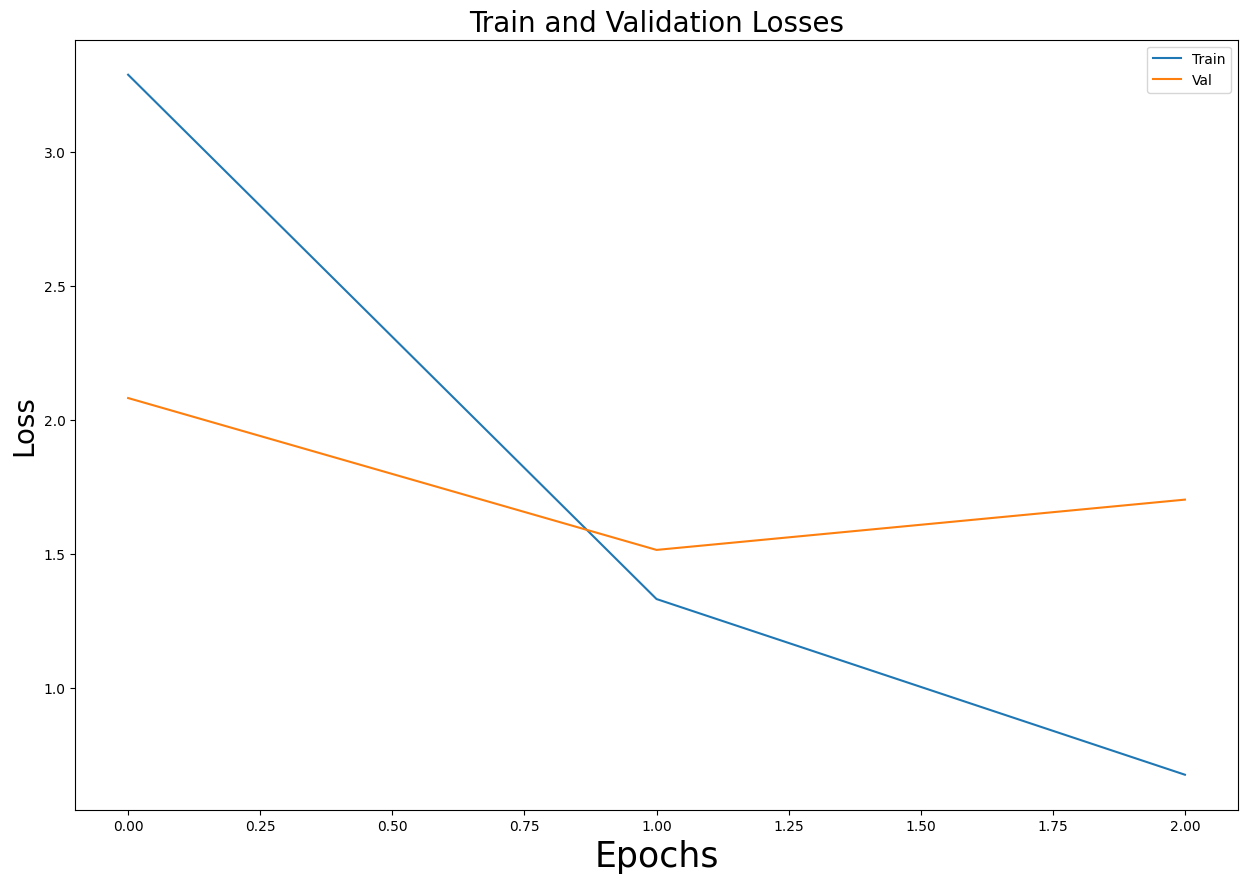

In [ ]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1,figsize=(15,10))

ax.set_title("Train and Validation Losses",size=20)
ax.set_ylabel('Loss', fontsize = 20)
ax.set_xlabel('Epochs', fontsize = 25)
_=ax.plot(train_losses)
_=ax.plot(val_losses)
_=ax.legend(('Train','Val'),loc='upper right')